# Day 2：基于交易量的量化指标 - 数据准备

本notebook主要介绍如何获取A股股票数据，为后续的指标计算和策略实现做准备。

## 1. A股数据来源介绍

获取A股行情数据的常用方法有以下几种：

1. **Tushare**：专注于金融数据的开源Python库，提供基础的股票、基金、期货、期权等金融数据
2. **AKShare**：另一个开源金融数据接口库，涵盖金融、经济、特色数据等
3. **通联数据**：专业金融数据服务提供商，需付费使用
4. **Wind/万得资讯**：国内领先的金融数据服务商，需付费使用
5. **东方财富Choice数据**：东方财富旗下的金融数据平台
6. **CSV文件**：从其他渠道下载的历史数据文件

本教程以**Tushare**为例，展示如何获取A股股票的历史行情数据。

## 2. 安装并配置Tushare

In [1]:
# 安装Tushare（如果尚未安装）
# !pip install tushare

In [12]:
# 导入必要的库
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from dotenv import load_dotenv, find_dotenv

# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")

# Load it explicitly
load_dotenv(dotenv_path)

# 忽略警告信息
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('ggplot')
%matplotlib inline

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [13]:
# 设置Tushare的Token（需要先在Tushare官网注册获取）
# 请在此处替换为您自己的Token
ts.set_token(os.getenv("TUSHARE_API_KEY"))
pro = ts.pro_api()

## 3. 获取A股股票列表

In [15]:
# 获取股票列表
stock_list = pro.stock_basic(exchange='', list_status='L', 
                             fields='ts_code,symbol,name,area,industry,list_date')
stock_list.head()

,ts_code,symbol,name,area,industry,list_date
0,000001.SZ,000001,平安银行,深圳,银行,19910403
1,000002.SZ,000002,万科A,深圳,全国地产,19910129
2,000004.SZ,000004,国华网安,深圳,软件服务,19910114
3,000006.SZ,000006,深振业A,深圳,区域地产,19920427
4,000007.SZ,000007,全新好,深圳,其他商业,19920413


## 4. 获取个股历史行情数据

我们选择几支具有代表性的A股股票，获取它们的历史日线数据。

In [16]:
# 设置时间范围
start_date = '20220101'
end_date = '20230101'

# 选择几支代表性股票的代码
# 平安银行 - 大型银行股
# 贵州茅台 - 白酒龙头
# 中国平安 - 保险龙头
stock_codes = ['000001.SZ', '600519.SH', '601318.SH']
stock_names = ['平安银行', '贵州茅台', '中国平安']

In [17]:
# 函数：获取单只股票的历史数据
def get_stock_data(ts_code, start_date, end_date):
    df = pro.daily(ts_code=ts_code, start_date=start_date, end_date=end_date)
    # 按日期升序排列
    df = df.sort_values('trade_date')
    # 将日期转换为datetime格式
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    # 设置日期为索引
    df.set_index('trade_date', inplace=True)
    return df

In [18]:
# 获取三只股票的数据并存储到字典中
stock_data = {}

for i, code in enumerate(stock_codes):
    try:
        stock_data[stock_names[i]] = get_stock_data(code, start_date, end_date)
        print(f"成功获取 {stock_names[i]} 的历史数据")
    except Exception as e:
        print(f"获取 {stock_names[i]} 数据时出现错误: {e}")

成功获取 平安银行 的历史数据
成功获取 贵州茅台 的历史数据
成功获取 中国平安 的历史数据


## 5. 数据预览与基本分析

In [19]:
# 查看平安银行的数据结构
stock_data['平安银行'].head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2022-01-04,000001.SZ,16.48,16.66,16.18,16.66,16.48,0.18,1.0922,1169259.33,1918887.050
2022-01-05,000001.SZ,16.58,17.22,16.55,17.15,16.66,0.49,2.9412,1961998.17,3344124.589
2022-01-06,000001.SZ,17.11,17.27,17.00,17.12,17.15,-0.03,-0.1749,1107885.19,1896535.837
2022-01-07,000001.SZ,17.10,17.28,17.06,17.20,17.12,0.08,0.4673,1126630.70,1937710.958
2022-01-10,000001.SZ,17.29,17.42,17.03,17.19,17.20,-0.01,-0.0581,909774.01,1563414.572


In [20]:
# 查看数据基本统计信息
stock_data['平安银行'].describe()

,open,high,low,close,pre_close,change,pct_chg,vol,amount
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,2.420000e+02,2.420000e+02
mean,13.861198,14.043595,13.678967,13.863760,13.876529,-0.012769,-0.063888,1.146620e+06,1.594644e+06
std,1.809829,1.837927,1.769727,1.808994,1.816725,0.292077,2.092741,5.524666e+05,7.944295e+05
min,10.330000,10.450000,10.220000,10.340000,10.340000,-1.210000,-7.534200,4.152534e+05,4.767492e+05
25%,12.385000,12.540000,12.280000,12.405000,12.405000,-0.187500,-1.286150,8.000329e+05,1.081736e+06
50%,14.045000,14.175000,13.795000,14.025000,14.080000,-0.010000,-0.077350,9.916103e+05,1.422705e+06
75%,15.092500,15.270000,14.835000,15.140000,15.195000,0.130000,0.988275,1.342646e+06,1.863890e+06
max,17.450000,17.560000,17.210000,17.410000,17.410000,1.180000,9.991500,4.749276e+06,6.026007e+06


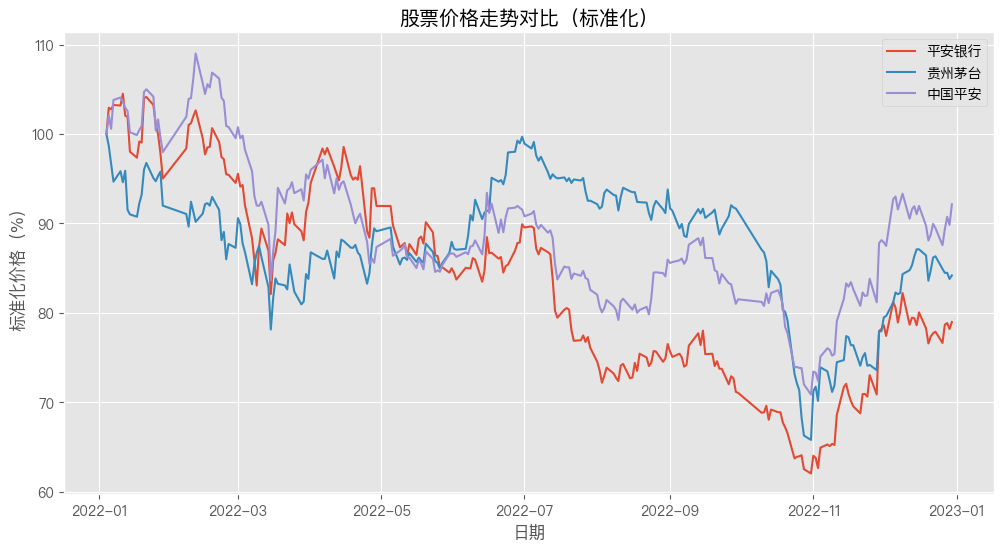

In [21]:
# 基本数据可视化
plt.figure(figsize=(12, 6))

for name, data in stock_data.items():
    # 价格标准化，便于比较
    normalized_price = data['close'] / data['close'].iloc[0] * 100
    plt.plot(data.index, normalized_price, label=name)

plt.title('股票价格走势对比（标准化）')
plt.xlabel('日期')
plt.ylabel('标准化价格（%）')
plt.legend()
plt.grid(True)
plt.show()

## 6. 保存数据到CSV文件（可选）

将获取的数据保存到本地，以便后续使用。

In [22]:
# 创建保存数据的文件夹（如果不存在）
import os
if not os.path.exists('data'):
    os.makedirs('data')

In [23]:
# 保存数据到CSV文件
for name, data in stock_data.items():
    file_path = f'data/{name}_data.csv'
    data.to_csv(file_path)
    print(f"已将{name}的数据保存到 {file_path}")

已将平安银行的数据保存到 data/平安银行_data.csv
已将贵州茅台的数据保存到 data/贵州茅台_data.csv
已将中国平安的数据保存到 data/中国平安_data.csv


## 7. 从CSV文件加载数据（可选）

如果已经有保存好的数据，可以直接从CSV文件中加载。

In [24]:
# 从CSV文件加载数据
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path, index_col=0)
    df.index = pd.to_datetime(df.index)
    return df

# 示例：加载平安银行的数据
# pingan_data = load_data_from_csv('data/平安银行_data.csv')
# pingan_data.head()

## 总结

在本notebook中，我们完成了以下任务：

1. 安装并配置了Tushare数据接口
2. 获取了A股股票列表
3. 获取了三只代表性股票的历史行情数据
4. 对数据进行了基本的可视化和分析
5. 学习了如何保存和加载数据

这些数据将在后续的指标计算和策略实现中使用。